In [99]:
import numpy as np
import matplotlib.pyplot as plt
import random
from queue import PriorityQueue


#Environment with random grid, terrain, obstacle, start point, destination point, battery level
class Environment:
    def __init__(self, size, grid_width=0.1):
        self.size = size
        self.grid_width = grid_width
        self.grid = np.zeros((size, size))
        self.obstacles = []
        self.start = (0, 0)
        self.destination = (size - 1, size - 1)
        self.terrain = np.ones((size, size))

    def generate_obstacles(self, num_obstacles):
        self.obstacles = random.sample([(i, j) for i in range(self.size) for j in range(self.size) if (i, j) != self.start and (i, j) != self.destination], num_obstacles)
        for obstacle in self.obstacles:
            self.grid[obstacle] = 1

    def visualize(self, path=None, battery_levels=None):
        plt.figure(figsize=(8, 8))
        plt.imshow(self.grid, cmap='Greys', origin='lower', alpha=0.5)
        plt.title('Dynamic Robot Movement Simulation', fontsize=16)
        plt.plot(*self.start, marker='o', color='lime', markersize=12, label='Start', zorder=3)
        plt.plot(*self.destination, marker='o', color='red', markersize=12, label='Destination', zorder=3)
        if path:
            path_x, path_y = zip(*path)
            plt.plot(path_y, path_x, marker='o', markersize=4, label='Path', zorder=2, linestyle='-')
            if battery_levels:
                for position, battery in zip(path, battery_levels):
                    plt.text(position[1], position[0], f"{int(battery)}%", ha='center', va='center', color='black', fontsize=11)
        for obstacle in self.obstacles:
            obstacle_x, obstacle_y = obstacle
            plt.fill([obstacle_y - 0.5 + self.grid_width, obstacle_y - 0.5 + self.grid_width, obstacle_y + 0.5 - self.grid_width, obstacle_y + 0.5 - self.grid_width, obstacle_y - 0.5 + self.grid_width],
                     [obstacle_x - 0.5 + self.grid_width, obstacle_x + 0.5 - self.grid_width, obstacle_x + 0.5 - self.grid_width, obstacle_x - 0.5 + self.grid_width, obstacle_x - 0.5 + self.grid_width],
                     color='black', zorder=1)
        plt.legend(fontsize=12)
        plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
        plt.xticks(np.arange(-0.5, self.size, step=1), fontsize=10)
        plt.yticks(np.arange(-0.5, self.size, step=1), fontsize=10)
        plt.xlabel('X', fontsize=14)
        plt.ylabel('Y', fontsize=14)
        plt.tight_layout()  # Adjust layout to prevent clipping of labels
        plt.show()

# Robot Class
class Robot:
    def __init__(self, environment):
        self.env = environment
        self.pos = self.env.start
        self.battery = 100
        self.moves = 0
        self.recharge_times = 0

    # Movement in the grid
    def move(self, direction):
        moves_dict = {'up': (-1, 0), 'down': (1, 0), 'left': (0, -1), 'right': (0, 1)}
        new_pos = tuple(np.add(self.pos, moves_dict[direction]))

        if not self.is_valid_move(new_pos):
            print("Invalid move! Try again.")
            return False

        self.pos = new_pos
        self.moves += 1
        self.battery -= 10

        if self.pos == self.env.destination:
            print("Destination reached!")
            print("Remaining charge at destination:", self.battery)
            return True

        if self.battery <= 0:
            print("Battery depleted. Recharging...")
            self.recharge()
            print("Battery recharged to 100%.")

        return False

    def is_valid_move(self, position):
        if position[0] < 0 or position[0] >= self.env.size or position[1] < 0 or position[1] >= self.env.size:
            return False
        if position in self.env.obstacles:
            return False
        return True

    def recharge(self):
        self.battery = 100
        self.recharge_times += 1
        print("Battery recharged to 100%.")

    def search(self, algorithm='astar'):
        if algorithm == 'astar':
            return self.astar_search()
        elif algorithm == 'ucs':
            return self.ucs_search()
        else:
            print("Invalid algorithm")
            return None, None

    # ASTAR search implementation
    def astar_search(self):
        visited = set()
        frontier = PriorityQueue()
        start = (0 + self.heuristic(self.env.start), self.env.start, [])

        frontier.put(start)

        while not frontier.empty():
            cost, current, path = frontier.get()
            if current in visited:
                continue
            visited.add(current)

            if current == self.env.destination:
                return path, cost

            x, y = current
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                new_x, new_y = x + dx, y + dy
                new_pos = (new_x, new_y)
                if self.is_valid_move(new_pos):
                    new_path = path + [new_pos]
                    new_cost = len(new_path) + self.heuristic(new_pos)
                    frontier.put((new_cost, new_pos, new_path))

        return None, None

    # UCS search implementation
    def ucs_search(self):
        visited = set()
        frontier = PriorityQueue()
        start = (0, self.env.start, [])

        frontier.put(start)

        while not frontier.empty():
            cost, current, path = frontier.get()
            if current in visited:
                continue
            visited.add(current)

            if current == self.env.destination:
                return path, cost

            x, y = current
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                new_x, new_y = x + dx, y + dy
                new_pos = (new_x, new_y)
                if self.is_valid_move(new_pos):
                    new_path = path + [new_pos]
                    new_cost = len(new_path)
                    frontier.put((new_cost, new_pos, new_path))

        return None, None

    def heuristic(self, position):
            return abs(position[0] - self.env.destination[0]) + abs(position[1] - self.env.destination[1])
    # Simulate for astar
    def simulate_movement(self, algorithm='astar'):
        path, cost = self.search(algorithm)
        if path:
            self.path = path
            battery_levels = []
            self.battery = 100
            for i in range(len(path) + 1):
                if self.battery == 0:  # Check and recharge battery if needed
                    self.recharge()
                battery_levels.append(self.battery)
                self.battery -= 10  # Decrease battery for the next move

            # Set the battery level at destination to match its actual value
            self.battery = battery_levels[-1]

            self.env.visualize([self.env.start] + path, battery_levels)
            print(f"Solution Path {algorithm.upper()}:", [self.env.start] + path)
            print("Total cost of path:", cost)
            print("Remaining charge at destination:", self.battery)  # Print remaining battery level at destination
            # Reset the robot's battery and position after simulation
            self.battery = 100
            self.pos = self.env.start
        else:
            print("No path found!")

    # Simulate for ucs
    def simulate_movement_ucs(self):
        self.simulate_movement('ucs')

    def move_towards(self, position):
        x_diff = position[0] - self.pos[0]
        y_diff = position[1] - self.pos[1]
        if x_diff > 0:
            return self.move('down')
        elif x_diff < 0:
            return self.move('up')
        elif y_diff > 0:
            return self.move('right')
        elif y_diff < 0:
            return self.move('left')
        return False


Battery recharged to 100%.


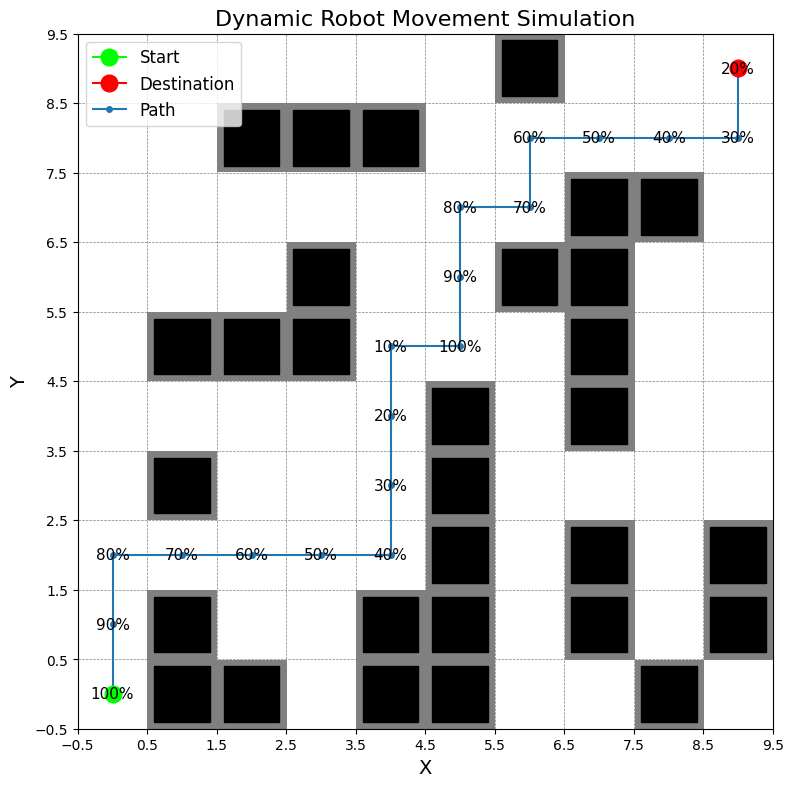

Solution Path UCS: [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 4), (4, 4), (5, 4), (5, 5), (6, 5), (7, 5), (7, 6), (8, 6), (8, 7), (8, 8), (8, 9), (9, 9)]
Total cost of path: 18
Remaining charge at destination: 20
Recharge times: 1


In [104]:
#================#
# UCS SEARCH RUN #
#================#
size = 10  # GRID SIZE
num_obstacles = 30  # OBSTACLE NUMBER

# Create the environment
env = Environment(size)
env.generate_obstacles(num_obstacles)

# Create the robot
robot = Robot(env)

# Run UCS search
algorithm = 'ucs'
robot.simulate_movement(algorithm)
print("Recharge times:", robot.recharge_times)


Battery recharged to 100%.


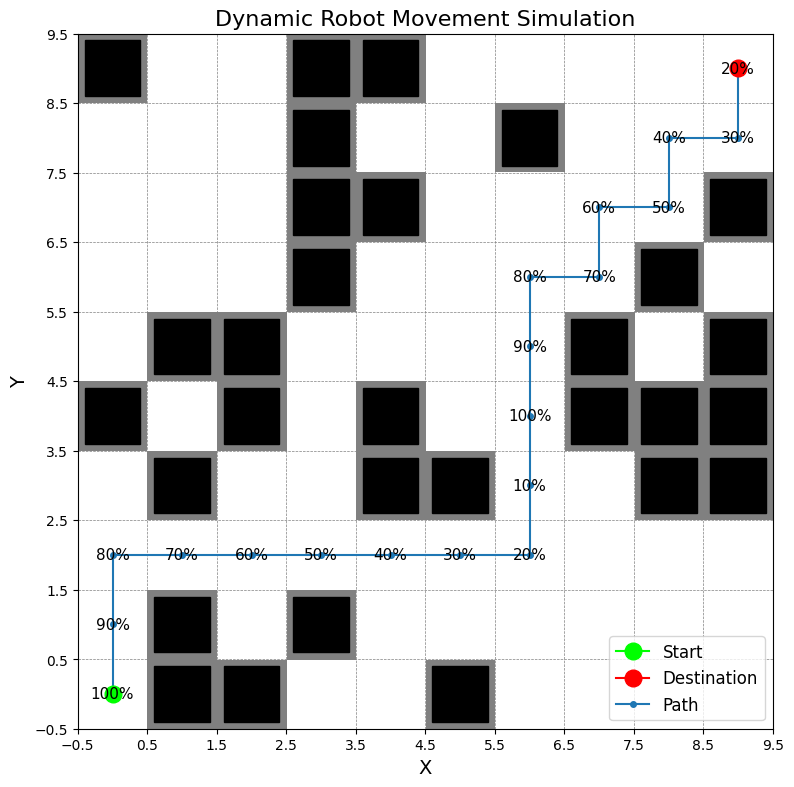

Solution Path ASTAR: [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 7), (7, 7), (7, 8), (8, 8), (8, 9), (9, 9)]
Total cost of path: 18
Remaining charge at destination: 20
Recharge times: 1


In [112]:
#==================#
# ASTAR SEARCH RUN #
#==================#
size = 10  # GRID SIZE
num_obstacles = 30  # OBSTACLE NUMBER

# Create the environment
env = Environment(size)
env.generate_obstacles(num_obstacles)

# Create the robot
robot = Robot(env)

# Run A* search
algorithm = 'astar'
robot.simulate_movement(algorithm)
print("Recharge times:", robot.recharge_times)
